In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import cross_val_score, cross_val_predict

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
diabetes = datasets.load_diabetes()

(442, 10)


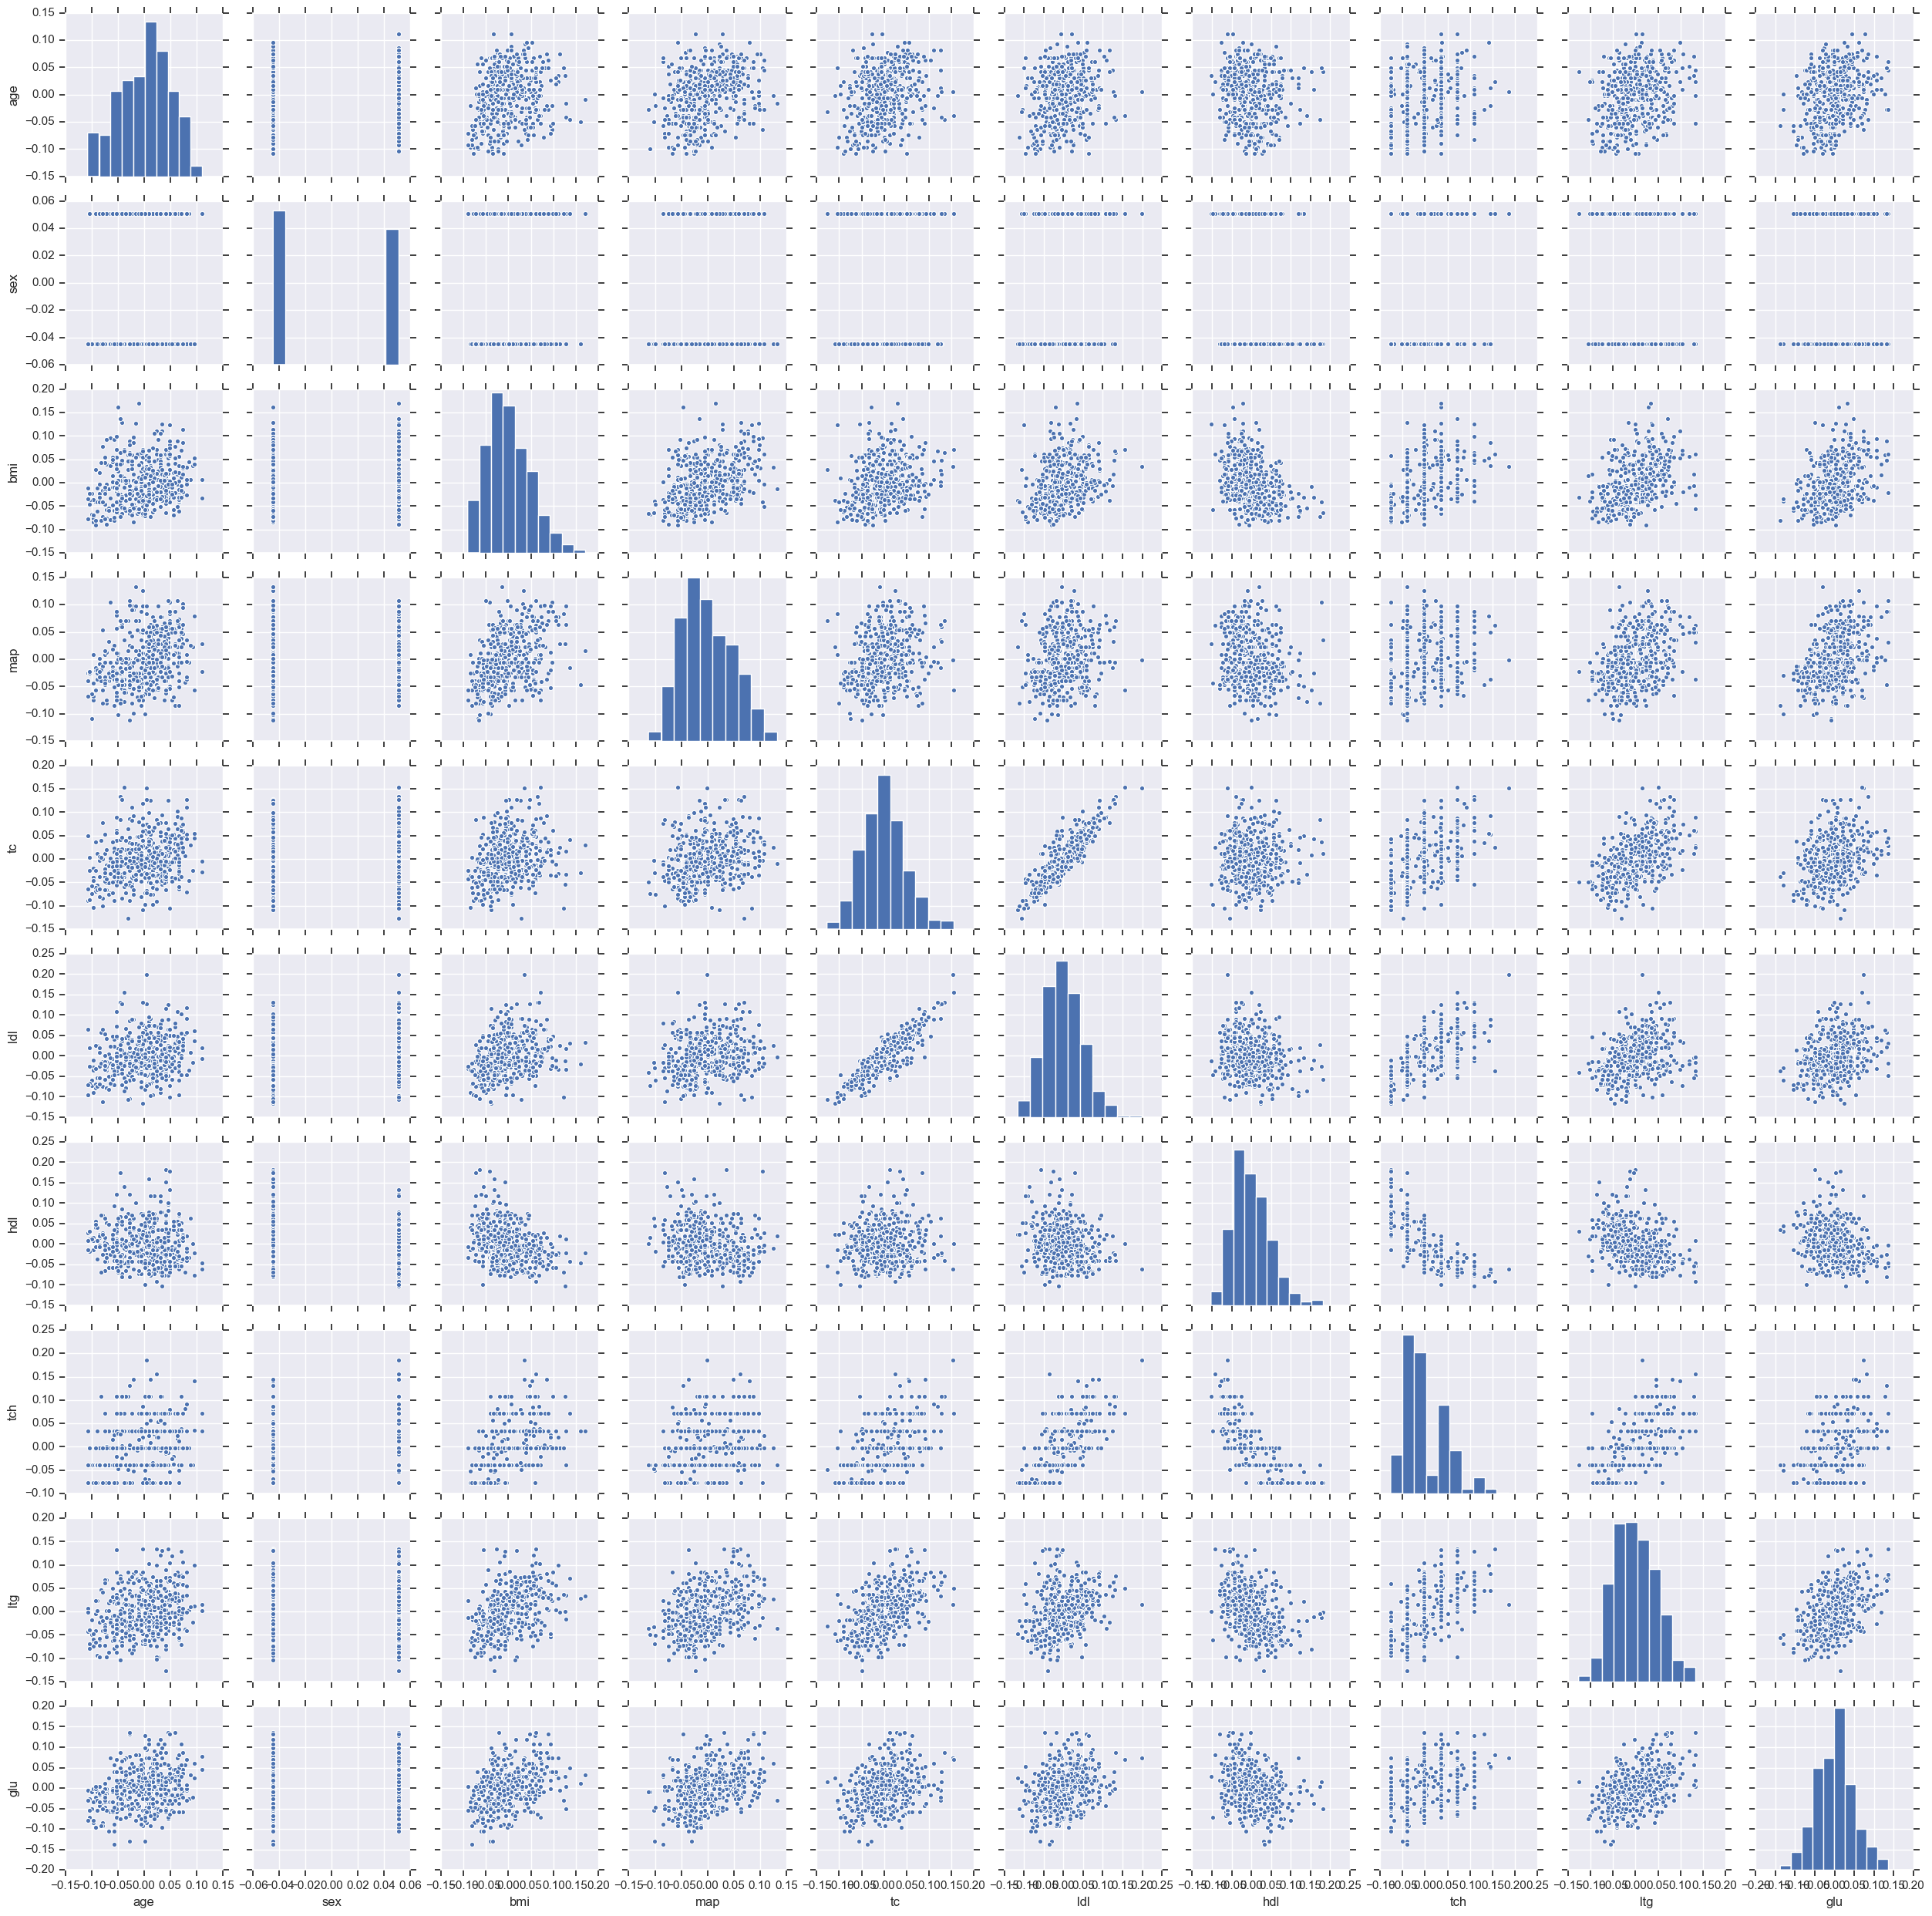

In [3]:
# View dict elements
diabetes.keys()

# View Data
print(diabetes.data.shape)
col_names = "age sex bmi map tc ldl hdl tch ltg glu".split()
data_frame = pd.DataFrame(diabetes.data, columns=col_names)
y = diabetes.target
sns.pairplot(data_frame)

In [4]:
# Check for extreme/suspicious values
for col_name in col_names:
    print(col_name,":",min(data_frame[col_name]),np.percentile(data_frame[col_name], 
        [25, 50, 75]),max(data_frame[col_name]))

age : -0.107225631607358 [-0.03729927  0.00538306  0.03807591] 0.110726675453815
sex : -0.044641636506989 [-0.04464164 -0.04464164  0.05068012] 0.0506801187398187
bmi : -0.0902752958985185 [-0.03422907 -0.00728377  0.03124802] 0.17055522598066
map : -0.112399602060758 [-0.03665645 -0.00567061  0.03564384] 0.132044217194516
tc : -0.126780669916514 [-0.03424784 -0.00432087  0.02835801] 0.153913713156516
ldl : -0.115613065979398 [-0.0303584  -0.00381907  0.02984439] 0.198787989657293
hdl : -0.10230705051742 [-0.03511716 -0.00658447  0.0293115 ] 0.181179060397284
tch : -0.076394503750001 [-0.03949338 -0.00259226  0.03430886] 0.185234443260194
ltg : -0.126097385560409 [-0.03324879 -0.00194763  0.03243323] 0.133598980013008
glu : -0.137767225690012 [-0.03317903 -0.0010777   0.02791705] 0.135611830689079


In [5]:
regr = linear_model.LinearRegression()

# LOO Cross-Validation 
scores = cross_val_score(regr, data_frame, y, cv=5)
print(scores)

[0.42955643 0.52259828 0.4826784  0.42650827 0.55024923]


First try LOO Cross-Validation using all possible models with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 variables. For each run, calculate $$RMSE = \sqrt{\frac{1}{n}\sum \limits_{i=1}^n (y_i - \widehat{y}_{(-i)})^2}$$

Then try a forward selection algorithm and see what it picks. Use the AIC criterion (or BIC).

If time try LASSO for variable selection

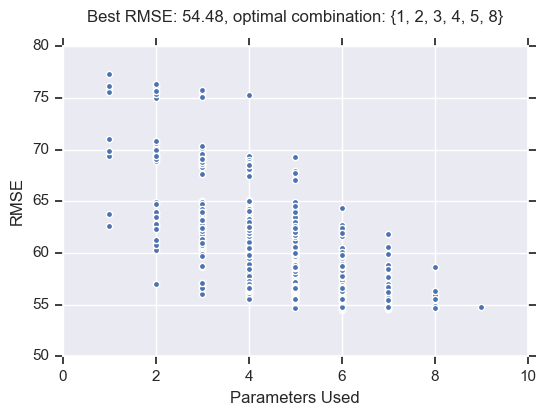

In [6]:
import itertools
from sklearn.model_selection import LeaveOneOut


def looRMSE(X, y):
    loo = LeaveOneOut()
    rmse = 0
    for train, test in loo.split(X):
        regr = linear_model.LinearRegression()
        regr.fit(X[train], y[train])
        rmse += (regr.predict(X[test])[0] - y[test][0])**2
        
    rmse = np.sqrt(rmse/(X.shape[0]))
    return rmse    
        
     
tested = []
result = []
numUsed = []
for i in range(len(col_names)):
    for j in range(1, i + 1):
        testCombos = itertools.combinations(np.arange(i), j)
        for c in testCombos:
            if set(c) in tested:
                continue
            tested.append(set(c))
            testSet = data_frame.values[:, c]
            result.append(looRMSE(testSet, y))
            numUsed.append(len(c))
            #print("{}, {}".format(set(c), result[-1]))
            
result = np.array(result)
tested = np.array(tested)
numUsed = np.array(numUsed)
plt.figure()
plt.scatter(numUsed,result)
plt.xlabel("Parameters Used")
plt.ylabel("RMSE")
plt.title("Best RMSE: {:.2f}, optimal combination: {}\n".format(result.min(), tested[result.argmin()]))
plt.show()
        
    
    
        

In [7]:
# Forward selection with AIC criterion
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

class ForwardSelector:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.used = np.zeros((X.shape[1])) # variables used in model, start with none

    def calculate_aic(self, y, yhat, k):
        e = 1./(y.shape[0] - (k+1)) * np.sum((y - yhat)**2)
        
        g = norm.pdf(y, yhat, np.sqrt(e))
        N = np.sum(np.log(g))
        
        aic = 2*(k + 1) - 2*N
        return aic

    def forward_select(self):
        current_best = np.iinfo(np.uint64).max
        new_best = current_best - 1
        
        while new_best < current_best:
            current_best = new_best
            candidate_scores = np.empty((self.X.shape[1]))
            print(current_best)
            for i in range(self.X.shape[1]):
                if self.used[i] == 1:
                    continue
                candidate_model = np.zeros((self.X.shape[1]))
                candidate_model[self.used==1] = 1
                candidate_model[i] = 1
                dset = self.X[:, candidate_model==1]
                regr = linear_model.LinearRegression()
                regr.fit(dset, self.y)
                yhat = regr.predict(dset)
                candidate_scores[i] = self.calculate_aic(self.y, yhat, np.sum(candidate_model))
            new_best = np.min(candidate_scores)
            print(candidate_scores)
            if new_best < current_best:
                self.used[np.argmin(candidate_scores)] = 1
                
                
fs = ForwardSelector(data_frame.values, y)
fs.forward_select()
print(fs.used)

        
        

18446744073709551614
[5082.45051472 5097.51578071 4912.04275925 5002.51112878 5078.00624306
 5084.73890414 5023.44579667 5007.760337   4927.72768432 5028.42592113]
4912.042759250663
[4909.63456416 4913.99775639 4912.04275925 4877.49809481 4910.95113465
 4913.73280163 4888.17584812 4884.41416344 4828.40870966 4894.67651962]
4828.408709662464
[4830.36187758 4828.26457755 4912.04275925 4813.24392775 4821.71321057
 4827.51965988 4821.93900255 4829.67470578 4828.40870966 4828.2896369 ]
4813.243927745183
[4814.57041109 4809.5305057  4912.04275925 4813.24392775 4804.99098753
 4811.73398814 4805.44091616 4814.20898634 4828.40870966 4814.8518243 ]
4804.990987532463
[4806.84684471 4800.12451138 4912.04275925 4813.24392775 4804.99098753
 4800.96001287 4802.21034121 4801.93251891 4828.40870966 4806.04025419]
4800.124511377531
[4802.12283045 4800.12451138 4912.04275925 4813.24392775 4804.99098753
 4788.65856228 4790.17700723 4789.9725716  4828.40870966 4800.35299529]
4788.658562276495
[4790.6720419

In [10]:
# ridge regression
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

X_scaled = preprocessing.scale(data_frame.values)
rregr = linear_model.Ridge()
rregr.fit(X_scaled, y)
# Find alpha via cross validation
parameters = {"alpha": np.arange(0.05, 1.04, .05)}
clf = GridSearchCV(rregr, parameters)
clf.fit(X_scaled, y)
print(clf.cv_results_)
print(clf.best_estimator_)

{'std_score_time': array([4.70808396e-04, 0.00000000e+00, 0.00000000e+00, 4.70808396e-04,
       4.70696004e-04, 2.24783192e-07, 4.70808396e-04, 4.70583613e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.35629826e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.05233662e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.70809040e-04]), 'split0_test_score': array([0.46937104, 0.46943003, 0.46948327, 0.46953124, 0.46957436,
       0.46961302, 0.46964759, 0.46967838, 0.46970568, 0.46972978,
       0.4697509 , 0.46976928, 0.46978513, 0.46979862, 0.46980994,
       0.46981925, 0.46982668, 0.46983238, 0.46983647, 0.46983906]), 'param_alpha': masked_array(data=[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3,
                   0.35000000000000003, 0.4, 0.45, 0.5, 0.55,
                   0.6000000000000001, 0.6500000000000001,
                   0.7000000000000001, 0.7500000000000001, 0.8,
                   0.8500000000000001, 0.9000000000000001,
       

In [9]:
# lasso regression
lregr = linear_model.Lasso(alpha=.9)
lregr.fit(X_scaled, y)
print(lregr.coef_)
#TODO cross validate to find alpha on both ridge and lasso, do PCA

[ -0.          -9.50561486  24.85625715  14.1939035   -5.247736
  -0.         -10.41977104   0.35204902  24.53489734   2.63890461]
